# Regression logistique

Par Serigne DIOP

### Choix du modéle

Modèle statistique rapide et efficace, idéal pour les problèmes de classification binaire. Il fournit des probabilités, mais suppose une séparation linéaire des classes, ce qui peut être limitant.

Contrairement à la régression linéaire qui prédit des valeurs continues, la régression logistique prédit des probabilités et applique une transformation sigmoïde pour obtenir une sortie entre 0 et 1
Si la probabilité est > 0.5, on classe l’observation en 1 (Présence de cancer) Sinon, elle est classée en 0 (Pas de cancer)

Pour établir cette correspondance entre une variable continue, ici les prédicteurs, et une variable binaire, l'existance de cancer ou son abscence, nous allons utiliser une fonction mathématique qui s’appelle la sigmoïde donc voici l’équation et la représentation graphique.

$\huge
p(y = 1 | x) = \frac{1}{1 + e^{-(\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n)}}$

### Graphgique sigmoide

In [1]:
# Afficher une image locale
#from IPython.display import Image
#Image(filename="sigmoide.jpg")

### Importation des librairies

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import pickle  
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import seaborn as sns


## 1. Importation des ensembles d'entraînement et de test

In [3]:
with open('Variables/variables.pkl', 'rb') as f:
    (df, X_train, X_test, y_train, y_test,X_train_smote, y_train_smote) = pickle.load(f)

## 2. Regression logistique

### 2.1 Regression logistique par Défault

Nous entraînerons le modèle sur l'ensemble d'entraînement et le testerons sur l'ensemble de test, avec les paramètres laissés à leurs valeurs par défaut.

In [4]:
scaler = StandardScaler() # Normalisation des données
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test) 

# Entraînement du modèle de régression logistique
model_logreg = LogisticRegression(max_iter=2000, random_state=42)
model_logreg.fit(X_train_scaled, y_train_smote)

LogisticRegression(max_iter=2000, random_state=42)

#### Evaluation du modéle

In [5]:
# Prédictions
y_pred = model_logreg.predict(X_test_scaled)
y_prob = model_logreg.predict_proba(X_test_scaled)[:, 1]

# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy:.2f}")
print("\nRapport de Classification :\n", classification_report(y_test, y_pred))
print("\nMatrice de Confusion :\n", confusion_matrix(y_test, y_pred))

Précision du modèle : 0.90

Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.78      0.88      0.82         8

    accuracy                           0.90        29
   macro avg       0.86      0.89      0.88        29
weighted avg       0.90      0.90      0.90        29


Matrice de Confusion :
 [[19  2]
 [ 1  7]]


#### Courbe ROC

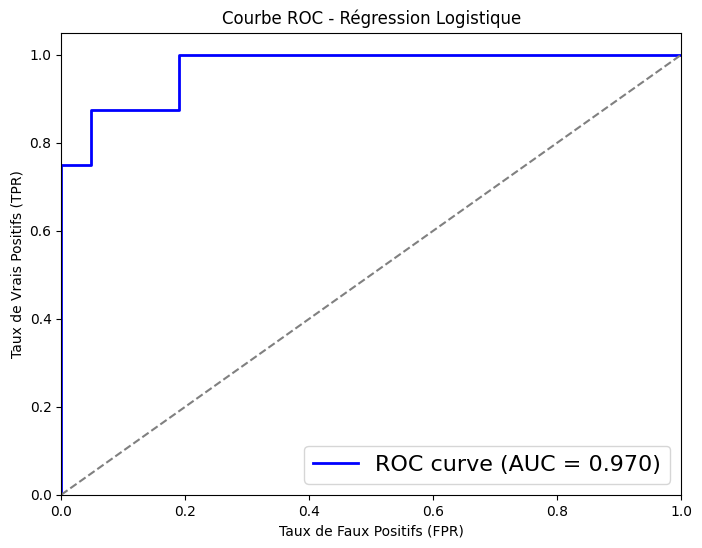

In [6]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Régression Logistique')
plt.legend(loc="lower right", fontsize=16)

plt.savefig("../Image/ROC_log1.png")
plt.show()

Notre modèle de régression logistique a une précision de 95 % et un AUC de 1, ce qui indique qu'il est performant sur l'ensemble de données. Cependant, la taille du test set étant petite, nous allons utiliser la validation croisée pour évaluer ses résultats de manière plus robuste

###  2.2 Regression logistique avec Cross-Validation

Nous allons maintenant effectuer une validation croisée sur l'ensemble du jeu de données, afin d'évaluer la performance du modèle en appliquant la validation croisée. Les paramètres du modèle seront laissés par défaut.


Précision moyenne du modèle : 0.900


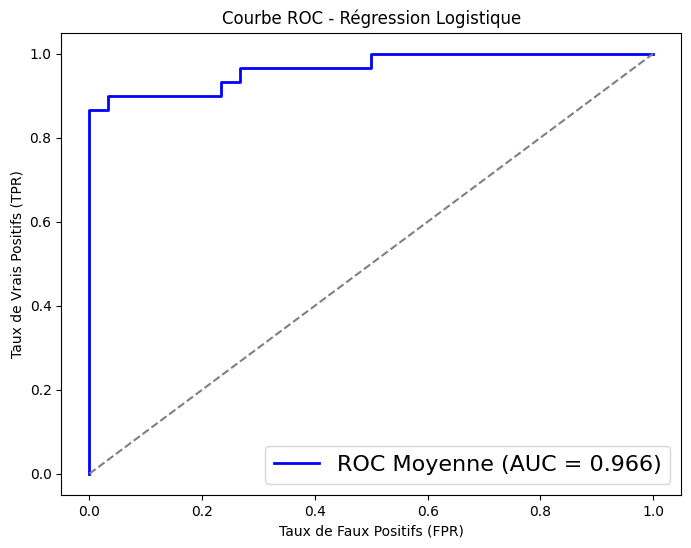

In [7]:
X = df.drop(["cancer_colUterus"], axis=1)
y = df["cancer_colUterus"]

model_logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=18)

cv = KFold(n_splits=5, shuffle=True, random_state=18) #5plis

y_prob = cross_val_predict(model_logreg, X_train_smote, y_train_smote, cv=cv, method="predict_proba")[:, 1]

accuracies = cross_val_score(model_logreg, X_train_smote, y_train_smote, cv=cv, scoring="accuracy")
mean_accuracy = np.mean(accuracies)

fpr, tpr, _ = roc_curve(y_train_smote, y_prob)
roc_auc = auc(fpr, tpr)

print(f"\nPrécision moyenne du modèle : {mean_accuracy:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Moyenne (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonale aléatoire
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Régression Logistique')
plt.legend(loc="lower right", fontsize=16)
plt.savefig("../Image/ROC_log2.png")
plt.show()

L'AUC du modèle de depart est supérieur à celui obtenu avec la cross-validation. Cela peut s'expliquer par la petite taille du dataset, qui entraîne un surapprentissage du modèle, le rendant moins généralisable à de nouvelles données

### 2.3 L'arbre de décision avec validation croisée dans le but d'optimisation des hyperparamètres.


Maintenant, nous n'appliquerons pas la validation croisée sur l'ensemble du dataset, mais uniquement sur le train set dans le but de trouver les hyperparamètres optimaux pour le modèle. Nous testerons également des méthodes, liblinear, lbfgs et saga, afin de déterminer la meilleure méthode avec ses paramètres optimaux.

Meilleurs hyperparamètres :  {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Meilleure précision obtenue :  0.9666666666666666

Précision moyenne du modèle après optimisation : 0.97


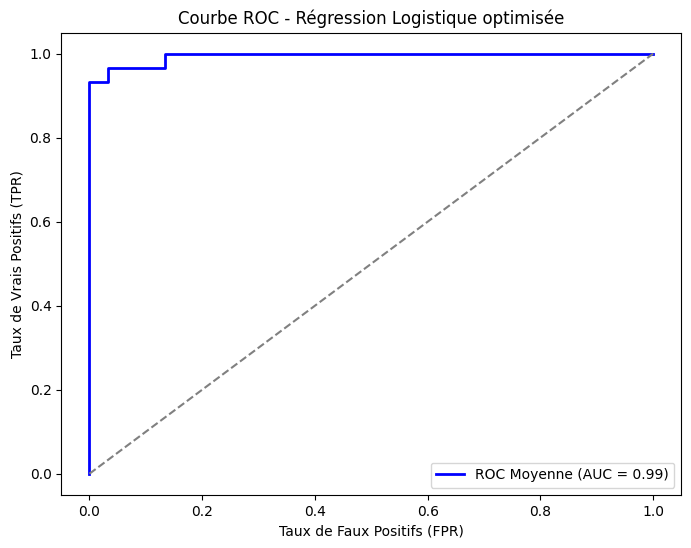

In [8]:
# Définition de la grille d'hyperparamètres pour GridSearchCV
param_grid = {
    'penalty': ['l2'],  # Type de régularisation
    'C': [0.01, 0.1, 1, 10, 100],  # Force de la régularisation
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Solveurs compatibles
    'max_iter': [1000, 2000, 5000]  # Nombre d'itérations
}

# Initialisation du modèle de régression logistique
model_logistic = LogisticRegression()

# Initialisation de la validation croisée à 5 folds
cv = KFold(n_splits=5, shuffle=True, random_state=18)

# Création de GridSearchCV avec validation croisée
grid_search = GridSearchCV(estimator=model_logistic, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy')

# Entraînement avec validation croisée
grid_search.fit(X_train_smote, y_train_smote)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Affichage de la meilleure précision obtenue
print("Meilleure précision obtenue : ", grid_search.best_score_)

# Récupération du meilleur modèle
best_model_opt = grid_search.best_estimator_

best_model_opt.fit(X_train_smote, y_train_smote)
# Prédictions des probabilités avec cross-validation
y_prob = cross_val_predict(best_model_opt, X_train_smote, y_train_smote, cv=cv, method="predict_proba")[:, 1]
y_prob = 1 - y_prob
# Précision moyenne obtenue
accuracies = cross_val_score(best_model_opt, X_train_smote, y_train_smote, cv=cv, scoring="accuracy")
mean_accuracy = np.mean(accuracies)

# Courbe ROC
tpr, fpr, _ = roc_curve(y_train_smote, y_prob)
roc_auc = auc(fpr, tpr)

# Affichage des résultats
print(f"\nPrécision moyenne du modèle après optimisation : {mean_accuracy:.2f}")

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Moyenne (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Régression Logistique optimisée')
plt.legend(loc="lower right")
plt.show()

**Remarque** : La courbe ROC ci-dessus est calculée sur le train set, car la validation croisée est utilisée uniquement pour trouver les meilleurs hyperparamètres sans interférer avec le test set.

Nous allons maintenant réentraîner le modèle avec la meilleure valeur de C trouvée sur l'ensemble du train set et tester les résultats sur le test set.

Confusion Matrix:
[[19  2]
 [ 1  7]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       0.78      0.88      0.82         8

    accuracy                           0.90        29
   macro avg       0.86      0.89      0.88        29
weighted avg       0.90      0.90      0.90        29



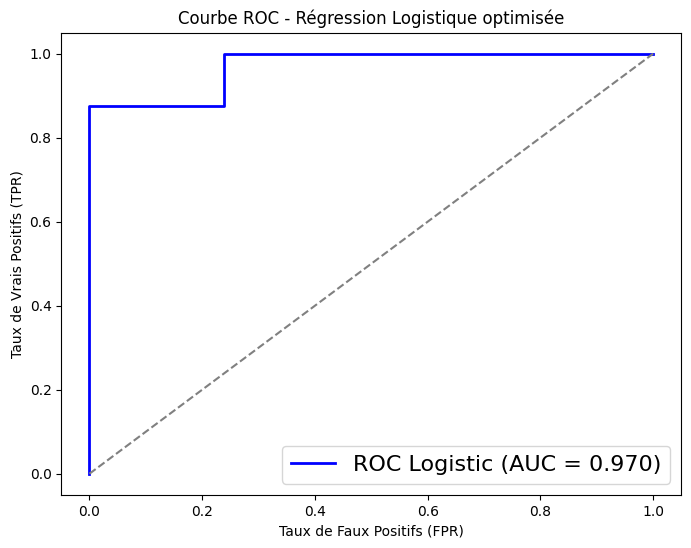

In [9]:
scaler = StandardScaler() # Normalisation des données
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test) 

# Entraînement du modèle optimisé
best_model_opt.fit(X_train_scaled, y_train_smote)

# Prédictions sous forme de probabilités
y_pred_proba = best_model_opt.predict_proba(X_test_scaled)[:, 1]  # Probabilité de la classe positive

# Conversion des probabilités en classes (avec un seuil de 0.5 par défaut)
y_pred_class = (y_pred_proba >= 0.5).astype(int)

# Matrice de confusion et rapport de classification
conf_matrix = confusion_matrix(y_test, y_pred_class)
print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred_class))

# Calcul des courbes ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Logistic (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Régression Logistique optimisée')
plt.legend(loc="lower right", fontsize=16)
plt.savefig("../Image/ROC_log3.png")
plt.show()

## 3. Analyse et Interpretation du modéle

In [10]:
# Affichage des coefficients du modèle logistique
coefficients = best_model_opt.coef_[0]  # Accéder aux coefficients du modèle

# Affichage des coefficients et des noms des caractéristiques (variables)
features = X_train_smote.columns  # Les noms des caractéristiques, si X_train_smote est un DataFrame
coeff_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Trier les coefficients par ordre décroissant
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

# Affichage des résultats
print(coeff_df)

                            Feature  Coefficient
1         comportement_alimentation     0.127224
5                attitude_cohérence     0.093943
6              attitude_spontanéité    -0.004093
15       soutienSocial_instrumental    -0.014602
17       autonomisation_compétences    -0.119228
13         soutienSocial_émotionnel    -0.122069
12               motivation_volonté    -0.138641
0         comportement_risqueSexuel    -0.169773
14       soutienSocial_appréciation    -0.193858
16      autonomisation_connaissance    -0.237261
7          norme_personneImportante    -0.252881
11                 motivation_force    -0.256657
3             intention_aggrégation    -0.284848
18            autonomisation_désirs    -0.313562
4              intention_engagement    -0.319225
9          perception_vulnérabilité    -0.330880
2   comportement_hygienePersonnelle    -0.333856
8             norme_accomplissement    -0.360101
10              perception_sévérité    -0.495302


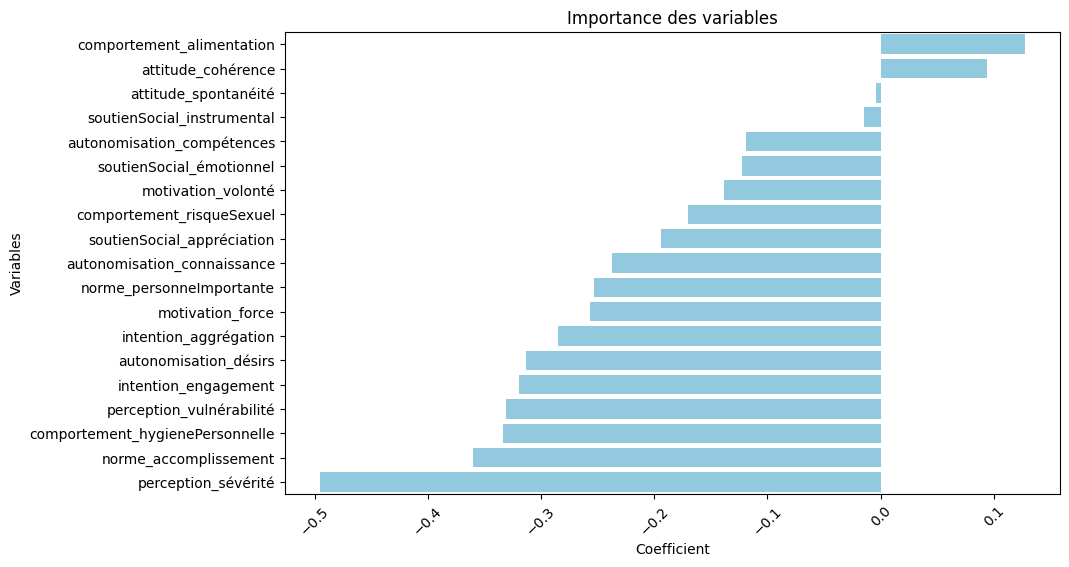

In [11]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Coefficient', y=coeff_df.Feature, data=coeff_df, color='skyblue')
plt.xticks(rotation=45)  # Faire pivoter les étiquettes de l'axe des abscisses
plt.xlabel('Coefficient')
plt.ylabel('Variables')
plt.title("Importance des variables")
plt.show()

Les coefficients obtenus par le modèle de régression logistique nous indiquent l'importance de chaque caractéristique (ou variable) dans la prédiction de la classe cible. En fonction du signe du coefficient (positif ou négatif) et de sa valeur, nous pouvons interpréter l'effet de chaque variable.

Les variables ayant des coefficients positifs tendent à favoriser l'appartenance à la classe cible (ex. : comportement alimentaire, cohérence d'attitude, soutien social instrumental). En revanche, les variables ayant des coefficients négatifs (notamment la perception de la gravité et de la vulnérabilité) semblent limiter cette appartenance. Ce modèle suggère que des caractéristiques telles que la perception de la gravité, la vulnérabilité et certains comportements d'engagement sont associés à un risque plus faible ou à une moins grande probabilité d'appartenir à la classe cible.

**Interpretation du modéle**

La régression logistique semble être parmis les meilleurs modèles ; elle capte les informations de toutes les variables, ce qui la rend particulièrement utile pour prédire le risque de cancer cervical en fonction de divers facteurs cliniques et biologiques. En analysant les caractéristiques des patientes, ce modèle peut fournir des prédictions précises sur le risque de cancer cervical.

## 4. Importer les variables

In [12]:
roc_data_log = {
    'fpr_log': fpr,
    'tpr_log': tpr,
    'auc_log': roc_auc,
    'pred_log' : y_pred_proba
}

# Sauvegarder les données dans un fichier pickle
with open('Variables/roc_data_log.pkl', 'wb') as file:
    pickle.dump(roc_data_log, file)

print("Les données ROC et AUC ont été enregistrées avec succès dans 'roc_data_log.pkl'.")

Les données ROC et AUC ont été enregistrées avec succès dans 'roc_data_log.pkl'.
